# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

In [ ]:
w=[[1,2,3],[4,5,6],[7,8,9]]
v=[[1,2,3],[4,5,6],[7,8,9]]
v_t=np.transpose(v)
print("v_t",v_t)
c=np.dot(w,v)
print("c",c)

In [ ]:
import numpy as np

sample_array = np.array([[1, 2, 3], [3, 4, 5]])
print("Sample array:", sample_array.shape)
mean = np.mean(sample_array, axis=0)
print("Mean:", mean)
final_array=sample_array-mean
print("final_array:", final_array)


In [ ]:
import numpy as np

# Normalize the array
array = np.array([1, 2, 3])
normalized_array = array / np.linalg.norm(array)
print("Normalized array:", normalized_array)

# Sample matrix
sample_matrix = np.array([[-2, -4, 2], [-2, 1, 2], [4, 2, 5]])
print("Sample matrix:", sample_matrix)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(sample_matrix)

print("eigen_vectors",eigenvectors)

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 2 eigenvectors
top_eigenvectors = sorted_eigenvectors[:, :2]

# Print the top 2 eigenvalues and eigenvectors
print("Top 2 eigenvalues:", sorted_eigenvalues[:2])
print("Top 2 eigenvectors:\n", top_eigenvectors)

# dot profuct of two matruxs
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.dot(a, b)
print("Dot product of a and b:", c)


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


Original Images


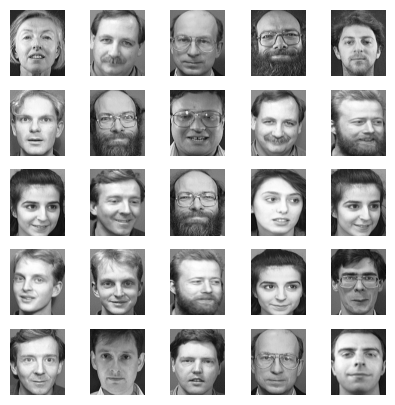

In [3]:
trainFaces = np.array(trainFaces)
trainFaces = trainFaces.reshape((trainFaces.shape[0], 112, 92))

trainfaces are basically total 360 images each of size 112*92. TrainLabels correspond to the labels of the images.

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [4]:
import scipy.misc
import matplotlib.pyplot as plt

# STEP 1 : RESPRESENT IMAGES USING VECTOR 

flattened_trainFaces=[]
print("total images",trainFaces.shape[0]) #360
for i in range(trainFaces.shape[0]):
    flattened_trainFaces.append(trainFaces[i].flatten())
flattened_trainFaces = np.array(flattened_trainFaces)
print("flattened_trainFaces shape",flattened_trainFaces.shape)



total images 360
flattened_trainFaces shape (360, 10304)


In [11]:
# STEP 2: COMPUTE THE MEAN FACE
mean_face = np.mean(flattened_trainFaces, axis=0)
print("mean_face_shape",mean_face.shape)

zero_mean_faces = flattened_trainFaces - mean_face
print("zero_mean_faces shape",zero_mean_faces.shape)



mean_face_shape (10304,)
zero_mean_faces shape (360, 10304)


In [37]:
# STEP 3 : GETTING COVARIANCE MATRIX
C = np.dot(np.transpose(zero_mean_faces), zero_mean_faces)

# FIND EIGEN VALUES AND EIGEN VECTOR 
eigen_values, eigen_vectors = np.linalg.eigh(C)

In [46]:
# let's us take only top 100 eigen vectors
top_eigen_vectors = eigen_vectors[:, -100:]
print("top_eigen_vectors shape",top_eigen_vectors.shape)

top_eigen_vectors shape (10304, 100)


In [48]:
 
# STEP 5 : COMPUTE WEIGHTS

weights = np.dot(zero_mean_faces, top_eigen_vectors)
print("weights shape",weights.shape)



weights shape (360, 100)


In [60]:

import numpy as np

# Assuming 'weights' is a 2D array of shape (360, 100)
# Assuming 'eigen_vectors' is a 2D array of shape (10304, 100)

# Reshape weights to (360, 100, 1) to facilitate broadcasting
weights_reshaped = weights.reshape(360, 100, 1)

# Multiply each weight by the corresponding eigen vector for each image
result = np.sum(weights_reshaped * top_eigen_vectors.T, axis=1)

print("result shape",result.shape)

# 'result' now contains the element-wise weighted sum for each image


result shape (360, 10304)


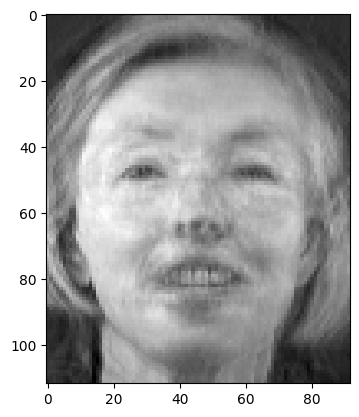

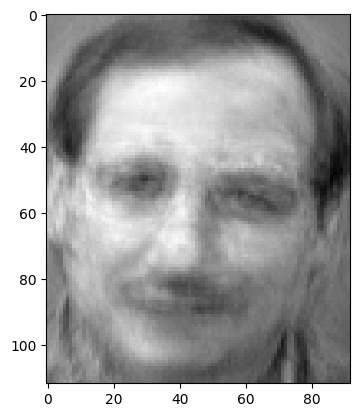

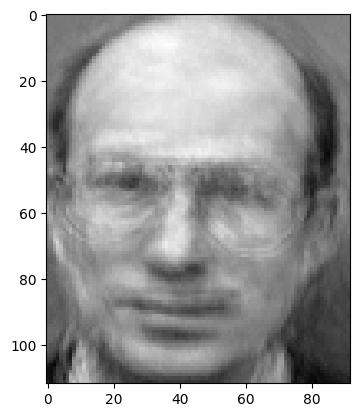

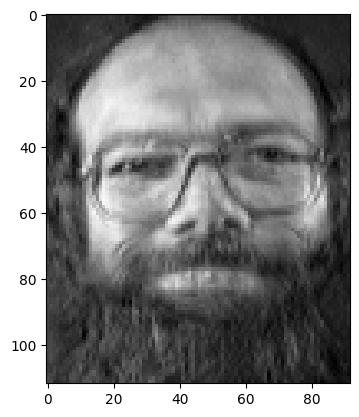

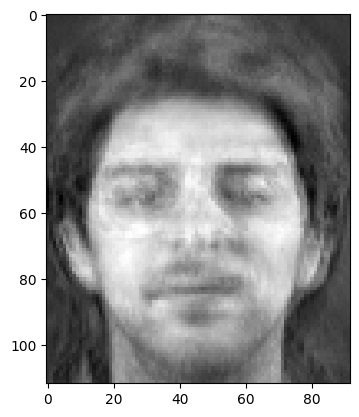

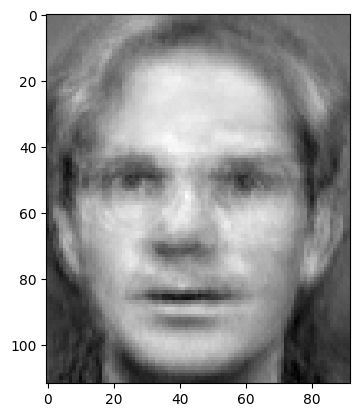

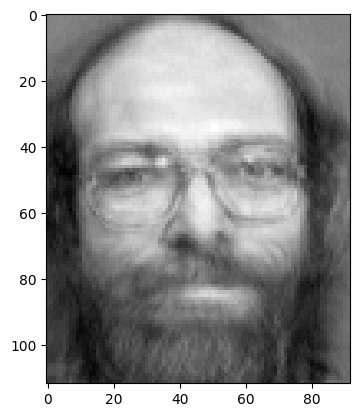

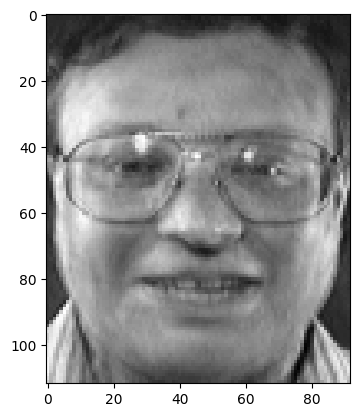

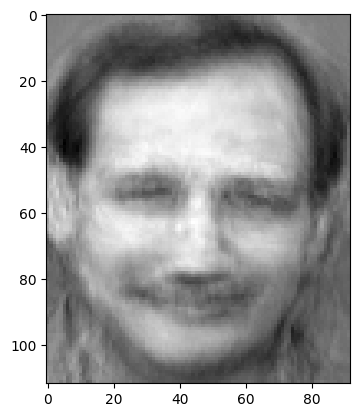

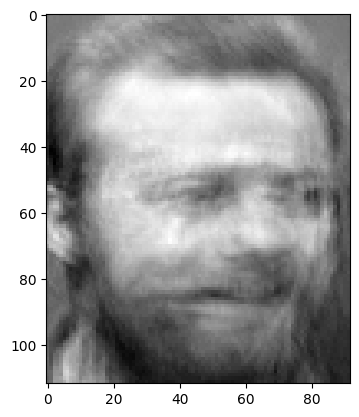

In [61]:
# STEP 6 : RECONSTRUCT THE FACES Ir= meanface + eigen faces*weights

reconstrcuted_faces = result + mean_face

reconstrcuted_faces_resize = reconstrcuted_faces.reshape((reconstrcuted_faces.shape[0], 112, 92))

# Display the first 10 reconstructed faces
for i in range(10):
    plt.imshow(reconstrcuted_faces_resize[i], cmap='gray')
    plt.show()

In [ ]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """


#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

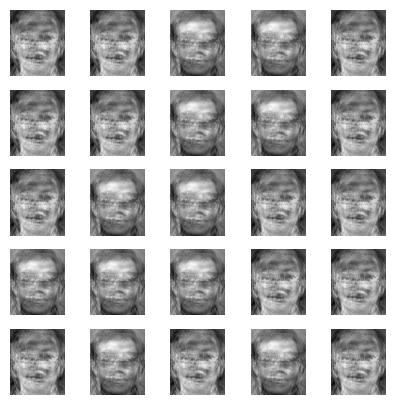

In [ ]:
# Corrected syntax errors
k = 360
weights = np.zeros((360, k))
# Basically for each of the 360 photos, I need to store the weight coefficient for each of the top eigenfaces

matrix_top_eigen = np.zeros((112 * 92, k))
c = 0

for val in range(k-1, -1, -1):
    matrix_top_eigen[:, c] = u_list[val].flatten()
    c = c + 1

reconstructed_faces = []

for face_num in range(0,360):
    w=np.dot(np.transpose(matrix_top_eigen), zero_mean_matrix[:, face_num])
    weights[face_num, :] = w
    reconstructed_face = np.dot(w,np.transpose(matrix_top_eigen))
    minf=np.min(reconstructed_face)
    maxf=np.max(reconstructed_face)
    reconstructed_face= reconstructed_face-float(minf)
    reconstructed_face= reconstructed_face/float(maxf-minf)
    reconstructed_face= reconstructed_face + np.transpose(mean_face)
    # reshpe ot 2d
    reconstructed_faces.append(reconstructed_face.reshape(112, 92))

griddisplay(reconstructed_faces)


In [ ]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
  
    # your code here

    return None

In [ ]:
# plot recontructions here
%matplotlib inline

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [ ]:
%matplotlib inline

def displayNfactors():

    # your code here

    return None

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
def getClass():
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    # your code here

    return None

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [ ]:
components = [3,5,10,20,30,40,50]
mse = []

for numComponents in components:
    # your code here

SyntaxError: incomplete input (1630759355.py, line 5)

Plot Number of eigenvectors vs Mean Square Error

In [ ]:
# your code here

Plot Number of eigenvectors vs Logarithmic Mean Square Error

In [ ]:
# your code here